## NYC 311 Calls Dashboard
##### Questions:
- best way to troubleshoot? was running server every time i made a new change, unable to trace where errors were coming from, would make edits and then spin up the entire server again
- best way to split code into separate files? start out in separate files, or start out in one file?
- have to convert strings to categories so that fuzzy match doesn't take forever, but then we cast these back to strings - is there a better way?
- why does the server run things more than once before opening the dashboard?
--------------------------------
- cant have y axis dynamically update
- legends choose arbitrary values
- if nan occurs in any value, plots nothing
- similar objects do not have similar arguments
- documentation for every object is (args, kwargs)
- weird things with jupyter lab?
- can't access turbo color palette?

### Setup / Import Data

In [1]:
import pandas as pd
import numpy as np
from sodapy import Socrata
import os
import seaborn as sns
from matplotlib import pyplot as plt
from fuzzywuzzy import process, fuzz
import pygsheets
from datetime import datetime, date, time, timedelta 
import json
import math 
import warnings
warnings.simplefilter("ignore")
pd.options.display.max_columns=50

from bokeh.plotting import figure, output_file, output_notebook, show, save, reset_output, gmap
from bokeh.models import (ColumnDataSource, GMapOptions, HoverTool, ColorBar, LinearColorMapper, Panel, 
                                            Tabs, CheckboxButtonGroup, CheckboxGroup, RadioButtonGroup, TextInput, 
                                                  Slider, DateRangeSlider, NumeralTickFormatter, Dropdown, Div, Select, BasicTicker)
from bokeh.palettes import brewer
from bokeh.transform import factor_cmap, transform, linear_cmap
from bokeh.layouts import column, row, layout, WidgetBox
from bokeh.io import output_file, show, curdoc


/Users/christinejiang/opt/anaconda3/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
#define parameters for endpoint, dataset, and app token
path ='../../data/'

data_url = 'data.cityofnewyork.us'
dataset = 'erm2-nwe9'
with open(path+'client_secret.json') as f:
    credentials = json.load(f)
app_token = credentials['app_token']

#sets up the connection, need application token to override throttling limits
#username and password only required for creating or modifying data
client = Socrata(data_url, app_token)
client.timeout = 6000

#count number of records in desired dataset
record_count = client.get(dataset, select='count(*)', where="created_date >='2020-01-01'")
total_count = record_count[0]['count']
print(total_count)

830012


In [4]:
def get_data(chunk_size=100000, total_rows=int(total_count)):
    start = 0
    results=[]

    #paginate through dataset in sets of 10000 to get all records since start of 2020
    while True:
        print(f'{start} rows retrieved')
        results.extend(client.get(dataset,select="unique_key, created_date, closed_date, agency, agency_name, complaint_type, descriptor, location_type, incident_zip, borough, address_type, city, status, latitude, longitude, location", 
                                  where="created_date >= '2020-02-01'", 
                                  limit=chunk_size, offset=start))
        start += chunk_size
        if start > total_rows:
            break
    return results

##### Only run if getting new data

In [5]:
orig_results = get_data()
orig_df = pd.DataFrame(orig_results)
orig_df.to_csv(path+'311_data.csv', index=False)

0 rows retrieved
100000 rows retrieved
200000 rows retrieved
300000 rows retrieved
400000 rows retrieved
500000 rows retrieved
600000 rows retrieved
700000 rows retrieved
800000 rows retrieved


In [6]:
path ='../../data/'
orig_df = pd.read_csv(path+'311_data.csv', 
                      usecols=['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
                            'complaint_type', 'descriptor', 'location_type', 'incident_zip', 'borough',
                            'city', 'status', 'latitude', 'longitude', 'location'], 
                      parse_dates=['created_date', 'closed_date'])

print(f'df shape: {orig_df.shape}')
print(f'df size: {orig_df.memory_usage().sum()/1024**2:.2f} MB')

df shape: (662411, 15)
df size: 75.81 MB


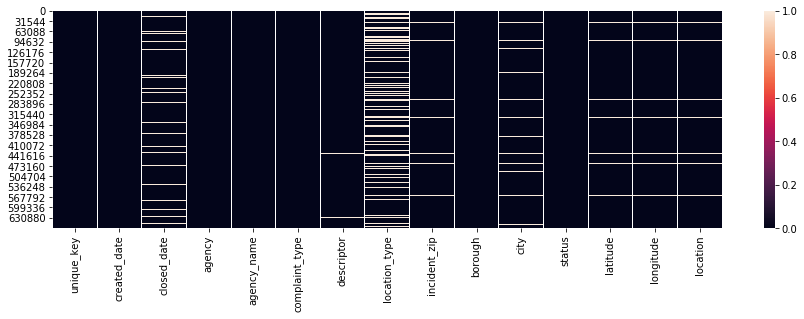

In [7]:
#display null values per column
plt.rc('figure',figsize=(15,4))
sns.heatmap(orig_df.isnull())

## Data Processing

In [8]:
def preprocess(df):
    df['created_mdy'] = pd.to_datetime(df['created_date'].dt.date)
    df['created_weekday'] = df['created_date'].dt.day_name()
    df['created_week'] = df['created_date'].dt.week
    df['created_hour'] = df['created_date'].dt.hour
    df['hour'] = df['created_date'].dt.strftime('%I %p')
    df['week_start'] = [x-timedelta(days=x.weekday()) for x in df['created_mdy']]
    df['count'] = 1
    
    #have to convert to categorical so that fuzzy match doesn't take forever
    #these get converted back to strings in order to plot
    df['agency_name'] = df['agency_name'].astype('category')
    df['complaint_type'] = df['complaint_type'].astype('category')
    df['descriptor'] = df['descriptor'].astype('category')
    df['location_type'] = df['location_type'].astype('category')
    df['city'] = df['city'].astype('category')
    df['borough'] = df['borough'].str.capitalize()
    #can't covert NAN to int, so convert to string
    df['incident_zip'] = df['incident_zip'].astype(str).str[0:5]
    df['borough'] = df['borough'].replace('Staten island', 'Staten_Island')
    return df

In [9]:
nyc_311_calls = preprocess(orig_df)

In [10]:
def export_col_values(workbook, df, columns):
    """For a list of columns, creates a new sheet for each column in the Google Sheets workbook and exports each column's unique values and their corresponding value counts to that sheet.
    Users can then use these value counts to determine the final clean categories for each column."""
    for col in columns:
        value_counts = df[col].value_counts()
        counts_df = pd.DataFrame(value_counts).reset_index()
        #cast any categorical columns to strings
        counts_df['index'] = counts_df['index'].astype(str)
        #if the worksheet doesn't already exist for that column, add one
        try:
            worksheet = workbook.worksheet_by_title(col)
        except Exception:
            #ensure the error is in regards to missing the worksheet
            print(sys.exc_info())
            workbook.add_worksheet(col)
            worksheet = workbook.worksheet_by_title(col)
        worksheet.set_dataframe(counts_df, start='A1')
        
def get_valid_names(workbook, columns, start='D1'):
    """Extract the valid names manually entered by the user in column D in each sheet of the workbook."""
    valid_names = {}
    for col in columns:
        worksheet = workbook.worksheet_by_title(col)
        valid_matrix = worksheet.get_values(start='D1', end='D100')
        valid_names[col] = [v[0] for v in valid_matrix]
    #return dictionary where keys are column names, and each value is a list of valid 'clean' categories
    return valid_names

def fuzzy_match(value):
    """Returns the best match for each column; fuzzy match score of < 90 will return 'Other'"""
    match = process.extract(query=value, choices=valid_names[col], limit=1)
    if match[0][1] < 90:
        return 'Other'
    else:
        return match[0][0]

In [11]:
#use pygsheets to connect to data cleaning workbook
client = pygsheets.authorize(service_account_file=path+'client_secret.json')
workbook = client.open('311_data_cleaning')
columns = ['agency_name','complaint_type','descriptor','location_type','city']

#export unique column values and their counts
export_col_values(workbook, nyc_311_calls, columns)

#get dictionary of lists with valid names for each column
#change values in column D of each tab if you wish to change the possible output values
valid_names = get_valid_names(workbook, columns, start='D1')

#fuzzy match each of the columns to the available values; create new 'cleaned' column 
for col in columns:
    nyc_311_calls['cleaned_'+col] = nyc_311_calls[col].apply(fuzzy_match)

print('Cleaned columns created.')

Cleaned columns created.


In [12]:
nyc_311_calls['descriptor'].value_counts()

Loud Music/Party               102201
Social Distancing               49106
ENTIRE BUILDING                 36301
Banging/Pounding                33124
No Access                       19945
                                ...  
Defective Street Cut (WZZ1)         1
Broken Lock                         1
Taste                               1
Tie Rods                            1
Inattentive                         1
Name: descriptor, Length: 794, dtype: int64

In [13]:
nyc_311_calls['cleaned_descriptor'].value_counts()

Other                      331425
Loud Music / Party         102201
Social Distancing           49106
Banging/Pounding            33124
No Access                   19945
Street Light Out            15570
Blocked Hydrant             15260
Pothole                     13730
Parking Sign Violation      10865
Noise                        8149
Partial Access               6950
Derelict Vehicles            6546
Pests                        6449
Face Covering Violation      6293
Wall / Ceiling               5790
Leak                         5547
Rat Sighting                 4746
Mold                         3332
Graffiti                     2871
Building / Apartment           12
Name: cleaned_descriptor, dtype: int64

## Bokeh Visualizations
- function to create bar graphs
- function to create tables
- function to create heatmaps
- function to create geo map
- function to create call outs
- add visualizations and sliders to dashboard

### Heatmap with Controls

In [14]:
def heatmap_tab(nyc_311_calls, x, y, title=None, x_ticks=None, y_ticks=None, x_label=None, y_label=None, exclude=None, tab_title='Heatmap'):
    
    #dataset for heatmap given x-category, y-category, boroughs, start date, and end date
    #user can indicate a value to exclude in either the x-category or y-category
    def make_dataset(x, y, boroughs, start_date, end_date):
        date_filter = nyc_311_calls[(nyc_311_calls['created_mdy'] >= start_date) & (nyc_311_calls['created_mdy'] <= end_date)]
        borough_filter = date_filter[date_filter['borough'].isin(boroughs)]
        pivot = borough_filter.pivot_table(values='count', index=x, columns=y, aggfunc='sum')
        pivot.columns = pivot.columns.astype(str)
        pivot.index = pivot.index.astype(str)
        if exclude:
            for exclusion in exclude:
                try:
                    pivot = pivot.drop(exclusion)
                except KeyError:
                    pivot = pivot.drop(exclusion, axis=1)
                except:
                    print('Exclusion does not exist in index or columns.')
        df_pivot = pd.DataFrame(pivot.stack()).reset_index()
        df_pivot.columns = ['x','y','value']
        return ColumnDataSource(df_pivot)
    
    def style(p):
        p.title.align = 'center'
        p.grid.visible=False
        p.title.text_font_size = '19pt'
        p.axis.axis_label_text_font_size = '12pt'
        p.axis.major_label_text_font_size = '10pt'
        
        p.title.text_font = 'avenir'
        p.axis.axis_label_text_font = 'avenir'
        p.axis.major_label_text_font = 'avenir'
        
        p.title.text_color = 'dimgray'
        p.axis.major_label_text_color = 'dimgray'
        p.axis.axis_label_text_color = 'dimgray'
        
        p.xaxis.axis_label = x_label
        p.yaxis.axis_label = y_label
        p.xaxis.major_label_orientation = math.pi/4
        
        p.title.text_font_style = 'normal'
        p.axis.axis_label_text_font_style = 'normal'
        p.axis.major_label_text_font_style = 'normal'
        p.xaxis.major_label_orientation = 'vertical'
        return p
    
    def make_plot(src):
        colors = ["#4f685f",'#64827c',"#75968f", "#a5bab7", "#c9d9d3", "#e2e2e2", "#f9eed4", "#f9d1ac", "#ddb7b1", "#cc7878", "#a54c4c","#933b41", "#550b1d"]        
        mapper = LinearColorMapper(palette='Magma256', low=src.data['value'].min(), high=src.data['value'].max())
        
        #user can indicate specific order for x or y ticks
        if x_ticks:
            x_range = x_ticks
        else:
            x_range = sorted(list(set(src.data['x'])))
        
        if y_ticks:
            y_range = y_ticks
        else:
            y_range = sorted(list(set(src.data['y'])))
        
        p = figure(plot_width=1100, plot_height=700, x_range=x_range, y_range=y_range, title=title)
        p.rect(x='x', y='y', width=1, height=1, source=src, line_color='white', fill_color=transform('value', mapper), fill_alpha=0.7)
        color_bar = ColorBar(color_mapper=mapper, location=(0,0), ticker=BasicTicker(desired_num_ticks=len(colors)), scale_alpha=0.7)
        p.add_layout(color_bar, 'right')
        hover = HoverTool(tooltips=[(y,'@y'), (x,'@x'), ('Calls','@value{0,0}')])
        p.add_tools(hover)
        p = style(p)
        return p
    
    def update(attr, old, new):
        boroughs_to_plot = [borough_selection.labels[i] for i in borough_selection.active]
        if isinstance(date_range_slider.value[0], (int, float)):
            start_date = pd.Timestamp(float(date_range_slider.value[0])*1e6)
            end_date = pd.Timestamp(float(date_range_slider.value[1])*1e6)
        else:
            start_date = pd.Timestamp(date_range_slider.value[0])
            end_date = pd.Timestamp(date_range_slider.value[1])
        new_src = make_dataset(x, y, boroughs_to_plot, start_date, end_date)
        src.data.update(new_src.data)
        print('plotting new stuff')
        p.rect(x='x', y='y', width=1, height=1, source=src, line_color='white', fill_color=transform('value', mapper))
        color_bar = ColorBar(color_mapper=mapper, location=(0,0), ticker=BasicTicker(desired_num_ticks=len(colors)))
        p.add_layout(color_bar, 'right')
        print('new stuff done')
    
    #set boroughs available for selection
    available_boroughs = list(set(nyc_311_calls['borough']))
    available_boroughs.sort()
    
    #checkbox for neighborhoods
    borough_selection = CheckboxGroup(labels=available_boroughs, active=[0,1,2,3,4,5])
    borough_selection.on_change('active', update)
    
    #date range selection
    date_range_slider = DateRangeSlider(title="Date Range: ", start=date(2020, 1, 1), end=date.today(), value=(date(2020, 1, 1), date.today()), 
                                        step=1, bar_color='#a5bab7', tooltips=True)
    date_range_slider.on_change('value',update)
    
    #set initial params
    initial_boroughs = [borough_selection.labels[i] for i in borough_selection.active]
    start_date = pd.to_datetime(date_range_slider.value[0])
    end_date = pd.to_datetime(date_range_slider.value[1])
    
    #create initial plot
    src = make_dataset(x, y, initial_boroughs, start_date, end_date)
    plot = make_plot(src)
    controls = WidgetBox(date_range_slider, borough_selection)
    layout = row(controls, plot)
    tab = Panel(child=layout, title=tab_title)
    return tab

### Bar Graph with Controls

In [15]:
def bargraph_tab(nyc_311_calls):
    
    #dataset for bar graph given boroughs, categorical variable, start date, and end date
    #only top 15 records are shown
    def make_dataset(boroughs, category, start_date, end_date):
        date_filter = nyc_311_calls[(nyc_311_calls['created_mdy'] >= start_date) & (nyc_311_calls['created_mdy'] <= end_date)]
        borough_filter = date_filter[date_filter['borough'].isin(boroughs)]
        df = pd.DataFrame(borough_filter.groupby([category, 'borough'])['count'].sum()).reset_index()
        df_pivot = df.pivot_table(values='count', index=category, columns='borough')
        df_pivot['sum'] = df_pivot.sum(axis=1)
        df_sorted = df_pivot.sort_values('sum', ascending=False).fillna(0)[:15]
        return ColumnDataSource(df_sorted)
        
    def style(p):
        p.title.align = 'center'
        p.title.text_font_size = '19pt'
        p.axis.axis_label_text_font_size = '12pt'
        p.axis.major_label_text_font_size = '10pt'
        
        p.title.text_font = 'avenir'
        p.axis.axis_label_text_font = 'avenir'
        p.axis.major_label_text_font = 'avenir'
        p.legend.label_text_font = 'avenir'

        p.title.text_color = 'dimgray'
        p.axis.major_label_text_color = 'dimgray'
        p.axis.axis_label_text_color = 'dimgray'
        p.xaxis.axis_label = 'Calls'
        
        p.title.text_font_style = 'normal'
        p.axis.axis_label_text_font_style = 'normal'
        p.axis.major_label_text_font_style = 'normal'
        p.legend.label_text_font_style = 'normal'
        
        p.toolbar_location = None
        p.xaxis.formatter=NumeralTickFormatter(format="0,0")
        p.legend.location = "bottom_right"
        return p
    
    #horizontal stacked bar graph: y-axis is unique category values, bars are split by boroughs
    def make_plot(src, title):
        active_category_values = list(reversed(src.data[active_category]))
        boroughs = [x for x in list(src.data.keys()) if x in available_boroughs]
        colors=brewer['YlGnBu'][len(boroughs)]
        p = figure(y_range=active_category_values, title=title, plot_height=700, plot_width=1100)
        p.hbar_stack(boroughs, y=active_category, height=0.9, source=src, color=colors, legend=[x.lower() for x in boroughs], fill_alpha=0.8)
        category_value = f'@{active_category}'
        #format number values in hover tool annotations as '10,000'
        hover = HoverTool(tooltips=[(display_category, category_value),
                                    ('Brooklyn', '@Brooklyn{0,0}'), 
                                    ('Bronx','@Bronx{0,0}'), 
                                    ('Staten Island', '@Staten_Island{0,0}'),
                                    ('Manhattan', '@Manhattan{0,0}'),
                                    ('Queens', '@Queens{0,0}'),
                                    ('Unspecified','@Unspecified{0,0}')])
        p.add_tools(hover)
        p = style(p)
        return p
        
    def update(attr, old, new):
        #set new categorical variable, boroughs, and colors to plot
        category_to_plot = labels_lookup[category_select.value]
        boroughs_to_plot = [borough_selection.labels[i] for i in borough_selection.active]
        colors=brewer['BuPu'][len(boroughs_to_plot)]
        #convert date range slider values to timestamp, given dtype of returned value
        if isinstance(date_range_slider.value[0], (int, float)):
            start_date = pd.Timestamp(float(date_range_slider.value[0])*1e6)
            end_date = pd.Timestamp(float(date_range_slider.value[1])*1e6)
        else:
            start_date = pd.Timestamp(date_range_slider.value[0])
            end_date = pd.Timestamp(date_range_slider.value[1])
        new_src = make_dataset(boroughs_to_plot, category_to_plot, start_date, end_date)
        src.data.update(new_src.data)
        
        #this isn't working - trying to plot new y axis and x axis label given values chosen
        category_to_plot_values = list(src.data[category_to_plot])
        p = figure(y_range=category_to_plot_values, title=category_to_plot, plot_height=700, plot_width=1100)
        p.hbar_stack(boroughs_to_plot, y=category_to_plot, height=0.9, source=src, color=colors, legend=[x.lower() for x in boroughs_to_plot])
        p.xaxis.axis_label = category_to_plot 
        p.title.text = display_category
        print(f'new category: {category_to_plot}, new boroughs: {boroughs_to_plot}, start: {start_date}, end: {end_date}')
    
    #set boroughs available for selection
    available_boroughs = list(set(nyc_311_calls['borough']))
    available_boroughs.sort()
    
    #checkbox for boroughs
    borough_selection = CheckboxGroup(labels=available_boroughs, active=[0,1,2,3,4,5])
    borough_selection.on_change('active', update)
    
    #slider for date range
    date_range_slider = DateRangeSlider(title="Date Range: ", start=date(2020, 1, 1), end=date.today(), value=(date(2020, 1, 1), date.today()), 
                                        step=10, bar_color='#8c96c6', tooltips=True)
    date_range_slider.on_change('value', update)
    
    #dropdown for which category to plot
    display_labels = ['Agency', 'City', 'Descriptor', 'Location Type', 'Status', 'Zip Code']
    actual_labels = ['agency_name', 'cleaned_city', 'cleaned_descriptor', 'cleaned_location_type', 'status', 'incident_zip']
    labels_lookup = {display:actual for display, actual in zip(display_labels, actual_labels)}
    category_select = Select(title="Category:", value='Agency', options=display_labels)
    category_select.on_change('value', update)
    
    #divider text for borough checkbox
    div = Div(text="""Borough:""", width=200, height=15)
    
    #set initial dataset params
    display_category = category_select.value
    active_category = labels_lookup[display_category]
    initial_boroughs = [borough_selection.labels[i] for i in borough_selection.active]
    start_date = pd.to_datetime(date_range_slider.value[0])
    end_date = pd.to_datetime(date_range_slider.value[1])
    
    #create initial plot
    src = make_dataset(initial_boroughs, active_category, start_date, end_date)
    p = make_plot(src, f'Calls by {display_category}')
    controls = WidgetBox(date_range_slider, category_select, div, borough_selection)
    layout = row(controls, p)
    tab = Panel(child=layout, title='Calls by Category')
    tabs = Tabs(tabs=[tab])
    return tab

### Geomap with Controls

In [16]:
def geomap_tab(nyc_311_calls):
    
    #load json file with map style
    #map styles to choose from: girly.txt, outspoken.txt, multibrand.txt
    with open('multibrand.txt') as json_file:
        map_style_json = json.load(json_file)
    map_style = json.dumps(map_style_json)
    
    def make_dataset(boroughs, display_num, start_date, end_date):
        #nyc_311_calls['created_mdy'] = pd.to_datetime(nyc_311_calls['created_mdy'])
        date_filter = nyc_311_calls[(nyc_311_calls['created_mdy'] >= start_date) & (nyc_311_calls['created_mdy'] <= end_date)]
        borough_filter = date_filter[date_filter['borough'].isin(boroughs)]
        borough_filter['lat_round'] = round(borough_filter['latitude'],3)
        borough_filter['lon_round'] = round(borough_filter['longitude'],3)
        latlon_df = pd.DataFrame(borough_filter.groupby(['lat_round', 'lon_round'])['count'].sum()).reset_index()
        latlon_df['sizes'] = latlon_df['count']/latlon_df['count'].max()*150
        latlon_sorted = latlon_df.sort_values('sizes', ascending=False)
        latlon_display = latlon_sorted[:display_num]
        return ColumnDataSource(latlon_display)
    
    def style(p):
        p.title.align = 'center'
        p.title.text_font_size = '19pt'
        p.axis.axis_label_text_font_size = '12pt'
        p.axis.major_label_text_font_size = '10pt'
        
        p.title.text_font = 'avenir'
        p.axis.axis_label_text_font = 'avenir'
        p.axis.major_label_text_font = 'avenir'
        
        p.title.text_color = 'dimgray'
        p.axis.major_label_text_color = 'dimgray'
        p.axis.axis_label_text_color = 'dimgray'
        
        p.xaxis.axis_label = 'Latitude'
        p.yaxis.axis_label = 'Longitude'
        
        p.title.text_font_style = 'normal'
        p.axis.axis_label_text_font_style = 'normal'
        p.axis.major_label_text_font_style = 'normal'
        return p
        
    def make_plot(src):
        with open(path+'client_secret.json') as f:
            data = json.load(f)
        api_key = data['google_api_key']
        map_options = GMapOptions(lat=40.76, lng=-73.95, map_type='roadmap', zoom=12, styles=map_style)
        call_map = gmap(api_key, map_options, title='311 Calls by Location', plot_width=850, plot_height=850)
        call_map.circle(x='lon_round', y='lat_round', size='sizes', source=src, fill_alpha=0.8, 
                        fill_color='tomato', line_color='firebrick')
        hover = HoverTool(tooltips=[('Longitude','@lon_round{0.0}'),
                                    ('Latitude','@lat_round{0.0}'), 
                                    ('Calls','@count{0,0}')])
        call_map.add_tools(hover)
        call_map = style(call_map)
        return call_map
    
    def update(attr, old, new):
        boroughs_to_plot = [borough_selection.labels[i] for i in borough_selection.active]
        top_n = int(display_labels[display_group.active][4:])
        if isinstance(date_range_slider.value[0], (int, float)):
        # pandas expects nanoseconds since epoch
            start_date = pd.Timestamp(float(date_range_slider.value[0])*1e6)
            end_date = pd.Timestamp(float(date_range_slider.value[1])*1e6)
        else:
            start_date = pd.Timestamp(date_range_slider.value[0])
            end_date = pd.Timestamp(date_range_slider.value[1])
        new_src = make_dataset(boroughs_to_plot, top_n, start_date, end_date)
        src.data.update(new_src.data)
    
    #set boroughs available for selection
    available_boroughs = list(set(nyc_311_calls['borough']))
    available_boroughs.sort()
    
    #checkbox for neighborhoods
    borough_selection = CheckboxGroup(labels=available_boroughs, active=[0,1,2,3,4])
    borough_selection.on_change('active', update)
    
    #radio button for top N records to display
    display_labels = ['Top 5', 'Top 100', 'Top 1000', 'Top 5000']
    display_group = RadioButtonGroup(labels=display_labels, active=3)
    display_group.on_change('active', update)
    
    #slider for date range
    date_range_slider = DateRangeSlider(title="Date Range", start=date(2020, 1, 1), end=date.today(), value=(date(2020, 1, 1), date.today()), 
                                        step=1, bar_color='goldenrod', tooltips=True)
    date_range_slider.on_change('value', update)
    
    div1 = Div(text="""Records to Display:""", width=200, height=15)
    div2 = Div(text="""Boroughs:""", width=200, height=15)
    
    #set initial dataset params
    initial_boroughs = [borough_selection.labels[i] for i in borough_selection.active]
    start_date = pd.to_datetime(date_range_slider.value[0])
    end_date = pd.to_datetime(date_range_slider.value[1])
    top_n = int(display_labels[display_group.active][4:])
    
    #create initial plot
    src = make_dataset(initial_boroughs, top_n, start_date, end_date)
    p = make_plot(src)
    controls = WidgetBox(date_range_slider, div1, display_group, div2, borough_selection)
    layout = row(controls, p)
    tab = Panel(child=layout, title='Calls by Location')
    return tab

### Linegraph with Controls

In [17]:
def linegraph_tab(nyc_311_calls, x, y):
    
    def make_dataset(x, y, boroughs):
        borough_filter = nyc_311_calls[nyc_311_calls['borough'].isin(boroughs)]
        borough_filter[x] = borough_filter[x].astype(str)
        borough_filter[y] = borough_filter[y].astype(str)
        pivot = borough_filter.pivot_table(values='count', index=x, columns=y, aggfunc=sum).reset_index()
        return ColumnDataSource(pivot)
    
    def style(p):
        p.title.align = 'center'
        p.title.text_font_size = '19pt'
        p.axis.axis_label_text_font_size = '12pt'
        p.axis.major_label_text_font_size = '10pt'
        
        p.title.text_font = 'avenir'
        p.axis.axis_label_text_font = 'avenir'
        p.axis.major_label_text_font = 'avenir'
        
        p.title.text_color = 'dimgray'
        p.axis.major_label_text_color = 'dimgray'
        p.axis.axis_label_text_color = 'dimgray'
        
        p.xaxis.axis_label = 'Latitude'
        p.yaxis.axis_label = 'Longitude'
        
        p.title.text_font_style = 'normal'
        p.axis.axis_label_text_font_style = 'normal'
        p.axis.major_label_text_font_style = 'normal'
        p.xaxis.major_label_orientation = math.pi/4
        return p
    
    def make_plot(src):
        p = figure(x_range=list(src.data[x]), title=f'311 Calls by {x} and {y}', plot_width=1000, plot_height=500)
        for col in src.data.keys():
            p.line(x=x, y=col, source=src, color='blue', legend=col)
        #factor_cmap(field_name='test', palette='Viridis256', factors=pivot.columns)
        date_value = f'@{x}'
        type_value = f'@{y}'
        hover = HoverTool(tooltips=[("Date", date_value), ('Type', type_value)])
        p.add_tools(hover)
        #p = style(p)
        return p
    
    def update(attr, old, new):
        boroughs_to_plot = [borough_selection.labels[i] for i in borough_selection.active]
        top_n = int(display_labels[radio_button_group.active][4:])
        #start_date = pd.Timestamp(float(date_range_slider.value[0])*1e6)
        #end_date = pd.Timestamp(float(date_range_slider.value[1])*1e6)
        start_date = pd.to_datetime(float(date_range_slider.value[0])*1e6)
        end_date = pd.to_datetime(float(date_range_slider.value[1])*1e6)
        new_src = make_dataset(boroughs_to_plot, top_n, start_date, end_date)
        src.data.update(new_src.data)
    
    available_boroughs = list(set(nyc_311_calls['borough']))
    available_boroughs.sort()
    
    #checkbox for neighborhoods
    borough_selection = CheckboxGroup(labels=available_boroughs, active=[0,1,2,3,4], name='Boroughs')
    borough_selection.on_change('active', update)
    
    #slider for date range
    date_range_slider = DateRangeSlider(title="Date Range", start=date(2020, 1, 1), end=date.today(), value=(date(2020, 1, 1), date(2020, 3, 1)), 
                                        step=1, bar_color='lightslategray', tooltips=True)
    date_range_slider.on_change('value', update)
    
    #set initial params
    initial_boroughs = [borough_selection.labels[i] for i in borough_selection.active]
    
    #create initial plot
    src = make_dataset(x, y, initial_boroughs)
    p = make_plot(src)
    controls = WidgetBox(date_range_slider, borough_selection)
    layout = row(controls, p)
    
    tab = Panel(child=layout, title='Calls over Time')
    return tab

### Create Dashboard

In [18]:
time_heatmap = heatmap_tab(nyc_311_calls, 'created_weekday','hour','Calls by Day and Hour', 
                           x_ticks=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
                           y_ticks=list(nyc_311_calls['hour'].unique())[::-1],
                           x_label='Day of Week',
                           y_label='Time of Day',
                           tab_title='Calls by Day/Hour')

category_heatmap = heatmap_tab(nyc_311_calls, 'week_start','cleaned_descriptor', 'Calls by Complaint Type', 
                               x_label='Week Start',
                               y_label='Complaint',
                               exclude=['Other'],
                               tab_title='Calls by Type')

geomap = geomap_tab(nyc_311_calls)

bargraph = bargraph_tab(nyc_311_calls)

linegraph1 = linegraph_tab(nyc_311_calls, 'created_mdy', 'cleaned_descriptor')

tabs = Tabs(tabs=[geomap, bargraph, time_heatmap, category_heatmap, linegraph1])
output_file('dashboard.html')
show(tabs)
curdoc().theme = 'light_minimal'
curdoc().add_root(tabs)

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/server.html



RuntimeError: Models must be owned by only a single document, LegendItem(id='1625', ...) is already in a doc

### Unused Functions

In [ ]:
# def reduce_memory(df):
#     """improved version of memory reduction function. uses pd.to_numeric to downcast types;
#     also considers whether there are few enough unique values to warrant use of category vs. object."""
#     orig_size = df.memory_usage().sum()/1024**2
#     dtypes = df.dtypes.astype(str).unique()
#     converted_float = pd.DataFrame()
#     converted_int = pd.DataFrame()
#     converted_obj = pd.DataFrame()
#     converted_misc = pd.DataFrame()

#     #convert floats
#     selected_float = df.select_dtypes(include='float')
#     converted_float = selected_float.apply(pd.to_numeric, downcast='float')
#     float_size = selected_float.memory_usage().sum()/1024**2
#     converted_float_size = converted_float.memory_usage().sum()/1024**2
#     print(f'floats: {float_size:.2f} reduced to {converted_float_size:.2f} MB')

#     #convert ints
#     selected_int = df.select_dtypes(include='integer')
#     converted_int = selected_int.apply(pd.to_numeric, downcast='integer')
#     int_size = selected_int.memory_usage().sum()/1024**2
#     converted_int_size = converted_int.memory_usage().sum()/1024**2
#     print(f'ints: {int_size:.2f} reduced to {converted_int_size:.2f} MB')
    
#     #convert objects / categories
#     selected_object = df.select_dtypes(include=['object', 'category'])
#     obj_size = selected_object.memory_usage().sum()/1024**2
#     for col in selected_object.columns:
#         count = len(selected_object[col])
#         unique = len(selected_object[col].astype(str).unique())
#         if unique < count/2:
#             converted_obj[col] = selected_object[col].astype(str).astype('category')
#         else:
#             converted_obj[col] = selected_object[col].astype(str)
#     converted_obj_size = converted_obj.memory_usage().sum()/1024**2
#     print(f'object: {obj_size:.2f} reduced to {converted_obj_size:.2f} MB')

#     #join floats, ints, and objects / categories
#     float_int = converted_float.join(converted_int)
#     float_int_obj = float_int.join(converted_obj)
    
#     #for any columns of any other type, keep them the same and join to the converted dataframe
#     no_change_cols = [x for x in df.columns if x not in float_int_obj.columns]
#     reduced_df = float_int_obj.join(df[no_change_cols])
    
#     #re-order columns to appear in original order
#     reduced_df = reduced_df[df.columns]
#     reduced_size = reduced_df.memory_usage().sum()/1024**2
#     print(f'final df: {orig_size:.2f} reduced to {reduced_size:.2f} MB, {(orig_size-reduced_size)/orig_size*100:.1f}% reduction')
#     return reduced_df